<a href="https://colab.research.google.com/github/sneezedsherry/DataVisualization/blob/master/stacked_barplot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#1 Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#2. Get the file
downloaded = drive.CreateFile({'id':'1s04DN96LISkHZ97e2_1pLbRxglhKx_CZ'}) 
downloaded.GetContentFile('MusicSales2.csv') 

In [0]:
#importing anything that I think will be useful in next steps:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [0]:
#Reading in MusicSales2.csv and storing it in a DataFrame named ms
ms = pd.read_csv('MusicSales2.csv')
ms.head(1)

,Album,Artist,Bytes,Sales,City,Company,Composer,Country,CustomerID,Email,...,MediaType,Milliseconds,Number of Records,Phone,PostalCode,Quantity,Region,State,Track,UnitPrice
0,Balls to the Wall,Accept,5.51M,3.96,Stuttgart,NaN,NaN,Germany,2,leonekohler@surfeu.de,...,Protected AAC audio file,342562,1,+49 0711 2842222,70174,4,Europe,NaN,Balls to the Wall,0.99


#### The Most Popular Genre in Asia & Europe

In [0]:
#sorting the target data in Aisa & Europe and named it as 'msae'
msae = ms[(ms.Region== 'Asia') | (ms.Region == 'Europe')].loc[: , ['Artist','Genre','Quantity','Region']]
msae.shape

(1089, 4)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(1000, 3.5, 'Top Selling Genre: Rock\nQuantity Sold: 1284')

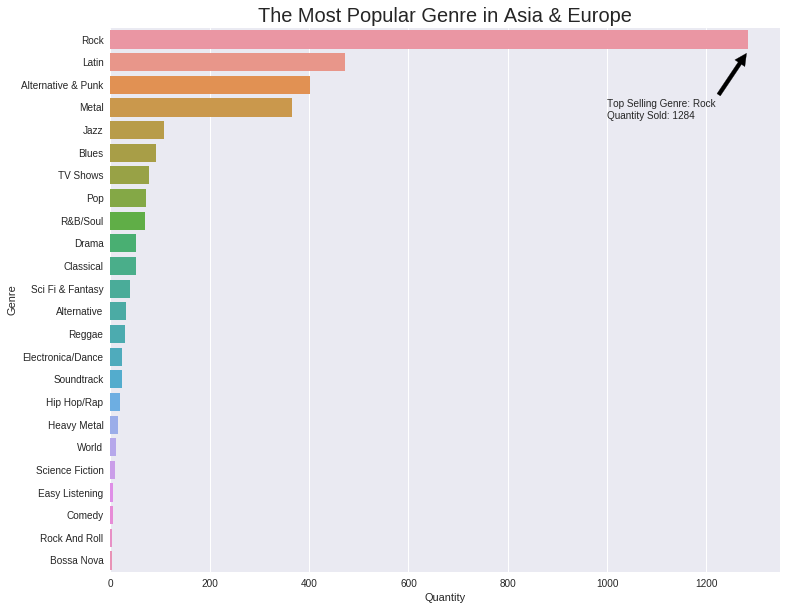

In [0]:
#Creating a dataframe that shows the most popular genre
popular_genre = msae.groupby('Genre', as_index = False).sum().sort_values(by = 'Quantity', ascending = False)

#Showing the horizontal barlpot
f, ax = plt.subplots(figsize=(12, 10))
ax = sns.barplot(x = "Quantity", y = "Genre" ,data = popular_genre)

plt.title('The Most Popular Genre in Asia & Europe', fontsize = 20)
plt.xlabel('Quantity')   

#Generating annotate
plt.annotate('Top Selling Genre: Rock\nQuantity Sold: 1284', xy=(1284, 0.5), xytext=(1000, 3.5),arrowprops=dict(facecolor='black', shrink=0.05))

#I think legend in this plot is redundant, because each color bar matches one genre.

####Top 20 Artists in Asia & Europe

In [0]:
import random
import matplotlib.patches as mpatches

artist = msae.groupby(['Artist'], as_index = False).sum().sort_values(by = 'Quantity', ascending = False).head(20)
artist_genre = msae.groupby(['Artist','Genre'], as_index = False).sum().sort_values(by = 'Quantity', ascending = False)
genre = artist_genre.loc[:,'Genre'].drop_duplicates().reset_index(drop = True)

for i, v in genre.items():
  artist[v] = int(0)
  for index, row in artist_genre.iterrows():
    if row['Genre'] == v:
      #print( row['Artist'], row['Quantity'])
      localMax = 0
      if artist.loc[artist.Artist == row['Artist'],:].size > 0:
        if i > 0:
          localMax = artist.loc[artist.Artist == row['Artist'], genre[0] : genre[i-1]].max(numeric_only = True, axis = 1)
          #print( artist.loc[artist.Artist == row['Artist'],:].size )
        artist.loc[artist.Artist == row['Artist'], v] = row['Quantity'] + localMax



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5, 0, 'Quantity')

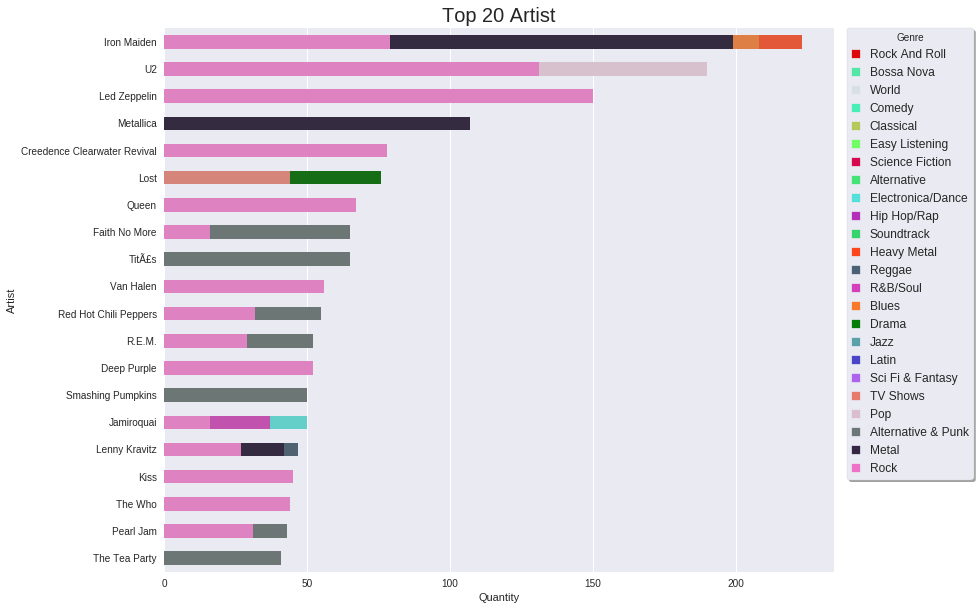

In [0]:
f, ax = plt.subplots(figsize=(12, 10))
  
customPatch = []
for i in reversed(genre):
  r = random.random()
  g = random.random()
  b = random.random()
  ax = sns.barplot(x = i, y = "Artist" ,data = artist, color = (r,g,b))
  #ax.legend(loc="lower right", frameon=True)
  customPatch.append( mpatches.Patch(color=(r,g,b), label=i) )
  
for patch in ax.patches :
  current_width = patch.get_height()
  diff = current_width - 0.5
  # we change the bar width
  patch.set_height(0.5)
  # we recenter the bar
  patch.set_y(patch.get_y() + diff * .5)
        
plt.title('Top 20 Artist', fontsize=20)
plt.legend(handles=customPatch, frameon=True, shadow=True ,prop={'size': 12}, title='Genre', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., handlelength=0.7)
plt.xlabel('Quantity')   

####Rock vs Alternative vs Heavy Metal in Asia &Europe

In [0]:
monthlymsae = ms[(ms.Region== 'Asia') | (ms.Region == 'Europe')].loc[: , ['Genre','Region','InvoiceDate','Sales']]
monthlymsae['InvoiceDate'] = pd.to_datetime(monthlymsae['InvoiceDate'],format='%m/%d/%Y %H:%M').dt.strftime("%Y-%m")
monthlymsae = monthlymsae.sort_values(by = 'InvoiceDate', ascending = False)

rock_monthly = monthlymsae[monthlymsae.Genre == 'Rock'].groupby(['InvoiceDate'], as_index = False).sum()
alternative_monthly = monthlymsae[(monthlymsae.Genre == 'Alternative & Punk')].groupby(['InvoiceDate'], as_index = False).sum()
heavy_metal_monthly = monthlymsae[monthlymsae.Genre == 'Heavy Metal'].groupby(['InvoiceDate'], as_index = False).sum()

monthly = rock_monthly
monthly = monthly.merge(alternative_monthly, how='outer', on='InvoiceDate', sort=True).merge(heavy_metal_monthly, how='outer', on='InvoiceDate', sort=True)

def interpolate_gaps(values, limit=None):
    """
    Fill gaps using linear interpolation, optionally only fill gaps up to a
    size of `limit`.
    """
    values = np.asarray(values)
    start = 0;
    end = values.size;
    found_none_NaN = False;
    for i in range(values.size):
      if np.isfinite( values[i] ):
        end = i;
        if found_none_NaN == False:
          found_none_NaN = True;
          start = i;

    i = np.arange(values.size)
    valid = np.isfinite(values)
    filled = np.interp(i, i[valid], values[valid])
    
    for i in range(start):
      filled[i] = np.nan;
    for i in range(end + 1,values.size):
      filled[i] = np.nan;

    return filled
  
monthly['Sales_x'] = interpolate_gaps(monthly['Sales_x'])
monthly['Sales_y'] = interpolate_gaps(monthly['Sales_y'])
monthly['Sales'] = interpolate_gaps(monthly['Sales'])

#monthly['InvoiceDate'] = pd.to_datetime(monthly['InvoiceDate'],format='%Y-%m')
monthly


,InvoiceDate,Sales_x,Sales_y,Sales
0,2008-01,36.63,NaN,NaN
1,2008-02,13.86,NaN,NaN
2,2008-03,8.91,NaN,NaN
3,2008-04,8.91,NaN,NaN
4,2008-05,20.79,33.6600,NaN
5,2008-06,13.86,21.2850,12.87000
6,2008-07,21.78,8.9100,12.59775
7,2008-08,52.47,8.9100,12.32550
8,2008-10,19.80,8.9100,12.05325
9,2008-11,53.46,26.7300,11.78100


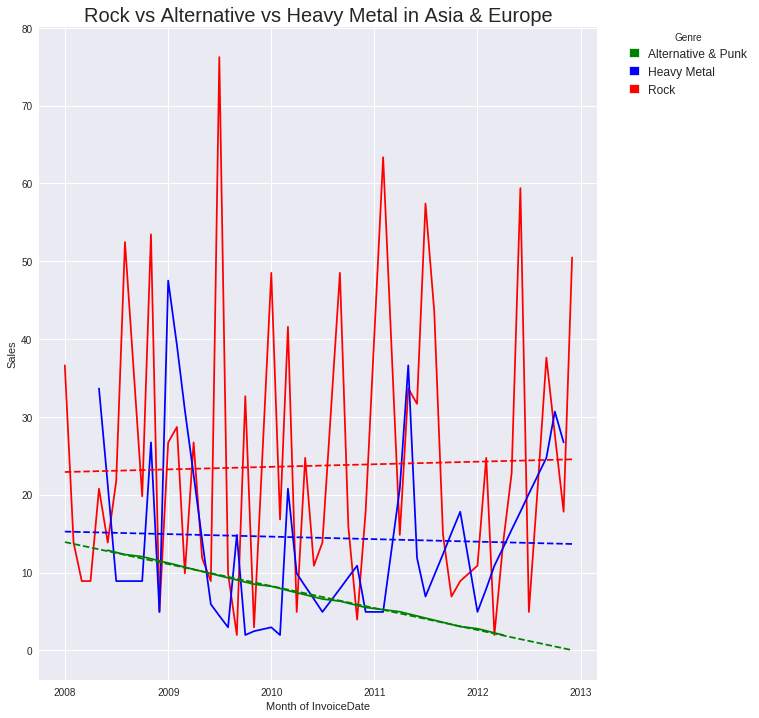

In [0]:
import matplotlib.dates as mdates
from datetime import datetime

f, ax = plt.subplots(figsize=(10, 12))
x = pd.to_datetime(monthly['InvoiceDate'],format='%Y-%m')
y1 = monthly['Sales_x']
y2 = monthly['Sales_y']
y3 = monthly['Sales']

#plt.scatter(x, y1, marker='o')


plt.plot( x, y1, 'r' )
plt.plot( x, y2, 'b' )
plt.plot( x, y3, 'g' )

def trend_line_plot( dates, values, c ):
  year_start = datetime(2008, 1, 1)
  days = np.array([(d - year_start).days + 1 for d in dates])
  start = 0
  end = values.size
  found_none_NaN = False
  for i in range(values.size):
    if np.isfinite( values[i] ):
      end = i;
      if found_none_NaN == False:
        found_none_NaN = True;
        start = i;
  
  slope, intercept = np.polyfit(days[start:end], values[start:end], 1)
  ideal_values = intercept + (slope * days)
  
  plt.plot(dates, ideal_values, color=c, linestyle='--')
  
trend_line_plot( x, y1, 'r' )
trend_line_plot( x, y2, 'b' )
trend_line_plot( x, y3, 'g' )

plt.title('Rock vs Alternative vs Heavy Metal in Asia & Europe', fontsize=20)
plt.xlabel('Month of InvoiceDate')
plt.ylabel('Sales')

customPatch = []
customPatch.append( mpatches.Patch(color='g', label='Alternative & Punk') )
customPatch.append( mpatches.Patch(color='b', label='Heavy Metal') )
customPatch.append( mpatches.Patch(color='r', label='Rock') )

plt.legend(handles=customPatch, prop={'size': 12}, title='Genre', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handlelength=0.7 )


IndexError: ignored

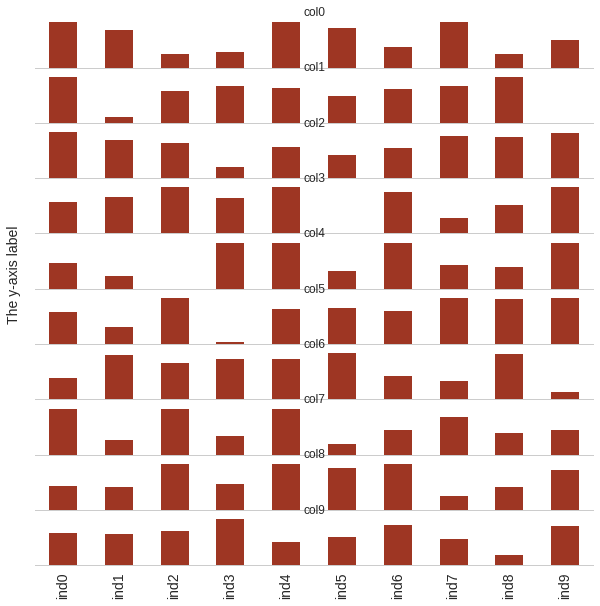

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#create dummy data
cols = ['col'+str(i) for i in range(10)]
ind = ['ind'+str(i) for i in range(10)]
df = pd.DataFrame(np.random.normal(loc=10, scale=5, size=(10, 10)), index=ind, columns=cols)

#create plot
sns.set_style("whitegrid")
axs = df.plot(kind='bar', subplots=True, sharey=True, 
              figsize=(10, 10), legend=False, yticks=[], 
              grid=False, ylim=(0, 14), edgecolor='none', 
              fontsize=14, color=[sns.xkcd_rgb["brownish red"]])
plt.text(-1, 100, "The y-axis label", fontsize=14, rotation=90)  # add a y-label with custom positioning
sns.despine(left=True)  # get rid of the axes
for ax in axs:  # set the names beside the axes
    ax.lines[0].set_visible(False)  # remove ugly dashed line
    ax.set_title('')
    sername = ax.get_legend_handles_labels()[1][0]
    ax.text(9.8, 5, sername, fontsize=14)
plt.suptitle("My panel chart", fontsize=18)

In [0]:
cols = ['col'+str(i) for i in range(10)]
ind = ['ind'+str(i) for i in range(10)]
df = pd.DataFrame(np.random.normal(loc=10, scale=5, size=(10, 10)), index=ind, columns=cols)
df

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9
ind0,6.685592,3.720956,10.020610,14.551678,2.948299,17.429369,16.259599,14.491325,2.774954,14.285243
ind1,21.044956,17.078632,1.329566,5.446365,14.857237,5.716552,6.301113,14.998989,3.046850,5.764465
ind2,9.555909,11.536395,11.404420,6.832405,3.394401,8.830066,13.775553,7.881926,12.191826,7.319396
ind3,11.091302,5.740623,6.151222,11.427117,-2.062573,4.892322,13.406710,10.903015,10.549594,13.017088
ind4,18.116073,7.627042,15.718077,9.337578,5.145819,16.914096,9.469675,7.020943,6.709791,3.229059
ind5,13.208081,12.580332,6.281323,12.856524,9.166091,6.841710,9.810779,8.922838,0.949751,2.224718
ind6,1.887183,12.157360,15.152513,10.856149,10.307509,6.479883,4.437009,17.377625,11.514532,18.053224
ind7,12.314576,11.412009,11.608570,7.351257,8.667145,5.296234,22.553876,2.565681,11.986596,13.229930
ind8,7.532922,4.709346,6.536866,8.753505,6.768071,16.048185,5.709044,8.517598,18.043197,14.426773
ind9,11.664698,8.154146,11.200507,5.453872,2.278373,0.674413,10.969271,13.694556,4.915454,19.126754
